# Short Interpolation using Kriging

In this notebook we test if the process works well if we average data taken in one calibration cycle before computing the ACF.

In [89]:
import numpy as np
import statistics as stat
import scipy
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import PrizmCalibration as cl # this module is missing dependencies
from gsm_data import GSMData, get_desired_frequencies
# from data_prep import DataPrep

# For reloading the module (useful for debugging)
import data
import data_prep
try:
    reload(data) # dependent module (imported in data_prep)
    reload(data_prep)
    from data_prep import DataPrep
except:
    from importlib import reload
    reload(data) # dependent module (imported in data_prep)
    reload(data_prep)
    from data_prep import DataPrep

from helper_functions import *
import data_utils as du

import copy

try:
    reload(test_short_interp)
    from test_short_interp import make_acf, make_acf_alt
except:
    import test_short_interp
    reload(test_short_interp)
    from test_short_interp import make_acf, make_acf_alt

from numpy.polynomial import polynomial as P

## Step 0: Load in data

In [2]:
# Flag the 'bad' spectra
# For a first pass I have to fetch the mask from DataPrep
year = '2021'
instrument = '100MHz'
channel = 'NS'

dataprep = DataPrep(instrument, channel, year)
save_mask = copy.deepcopy(dataprep.calib_mask_dict['short']) # save the mask

TypeError: object of type 'NoneType' has no len()

In [46]:
# Actually save the mask so I don't have to load it in every time anymore.
np.save(datadir+'shortdata_2021_100MHz_NS_mask.npy',save_mask)

In [121]:
datadir = '../test_data/2021/100MHz/NS/'

save_mask = np.load(datadir+'shortdata_2021_100MHz_NS_mask.npy')
dat=np.load(datadir+'shortdata_meas_2021_100MHz_NS.npy')[save_mask]
lst=np.load(datadir+'shortlst_2021_100MHz_NS.npy')[save_mask]
t=np.load(datadir+'shortsystime_2021_100MHz_NS.npy')[save_mask]
t_ant = np.load(datadir+'antsystime_2021_100MHz_NS.npy')

# dat_nomask = np.load(datadir+'shortdata_meas_2021_100MHz_NS.npy')
# lst_nomask = np.load(datadir+'shortlst_2021_100MHz_NS.npy')
# t_nomask = np.load(datadir+'shortsystime_2021_100MHz_NS.npy')

In [91]:
freqarr, freqstep = np.linspace(0,250,4096,retstep=True) # Based on number of frequency channels of the antenna
minfreq = 30
maxfreq = 200
minfreqarg = int(minfreq/freqstep)
maxfreqarg = int(maxfreq/freqstep)

In [4]:
print(np.diff(t_nomask))
tmax=1.6374e9
tmin=1.6365e9
freq = 100 # MHz
freq_index = int(freq/freqstep)
mask=(t_nomask>tmin)&(t_nomask<tmax)
plt.figure(figsize=(20,5))
plt.plot((t_nomask[mask]-t_nomask[mask][0])/3600,dat_nomask[mask,:][:,freq_index],'.',label='Selected section',zorder=0)

NameError: name 't_nomask' is not defined

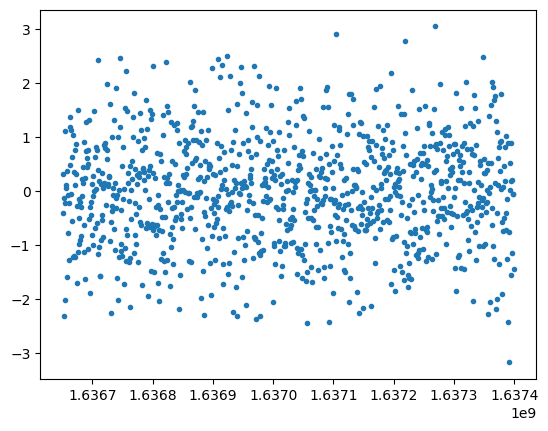

In [238]:
# White Gaussian Noise simulated data -- for testing purposes
twgn = np.linspace(np.min(tt),np.max(tt),1000)
wgn_data = np.random.normal(loc=0,scale=1,size=len(twgn))

plt.plot(twgn,wgn_data,'.',label='WGN data')
plt.show()

## Step 0: Average Data

0.6586859663327534 mins
346
(103,)
(492,)


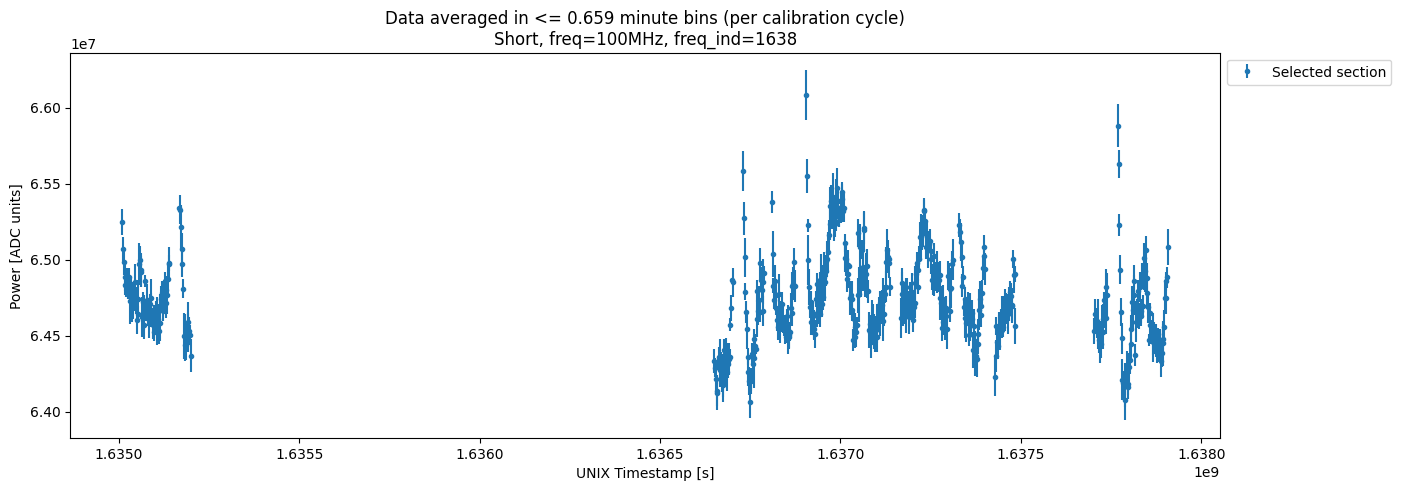

In [122]:
# tmax=1.6374e9
# tmin=1.6365e9
tmax=np.inf
tmin=0


mask=(t>tmin)&(t<tmax)
tt=t[mask]
dd=dat[mask,:]
ll=lst[mask]

''' Set frequency here'''
freq = 100 # MHz
freq_index = int(freq/freqstep)
'''-----------------------------'''

'''Smoothing data by binning, but keeping the dt=0 bin/peak intact!'''
# Separate the current dt values into bins within a few minutes of each other, I think this normally corresponds to data taken during the same rotation through calibrators before going back to antenna

# binwidth = 60*5 # 5 minute bins, 5*60 seconds time difference to be considered in the same bin

# Example array of time values in seconds (with large time gaps)
time_values = tt
dat_values = dd[:,freq_index]
tsteps = np.diff(time_values)

# Create bin edges based on big jumps in the timestep between subsequent measurementa
bins = np.where(tsteps>5*60)[0] # bin edges, minimum jump is 5*60 seconds
# print(bins)

# Split 
bin_tgroups = np.split(time_values,bins+1,axis=0)
bin_dat_groups = np.split(dat_values,bins+1,axis=0)

t_binavg = []
dat_binavg = []
dat_binstd = []
largest_binwidth = 0
largest_bini = 0

for i in range(len(bin_tgroups)):
    t_binavg.append(np.mean(bin_tgroups[i]))
    dat_binavg.append(np.mean(bin_dat_groups[i]))
    dat_binstd.append(np.std(bin_dat_groups[i]))
    if (bin_tgroups[i][-1]-bin_tgroups[i][0]) > 5*60:
        print('bin larger than 5 minutes:',(bin_tgroups[i][-1]-bin_tgroups[i][0])/60,'mins')
    if (bin_tgroups[i][-1]-bin_tgroups[i][0] > largest_binwidth):
        largest_binwidth = bin_tgroups[i][-1]-bin_tgroups[i][0]
        largest_bini = i

print(largest_binwidth/60,'mins')
print(largest_bini)

# Print the results
smoothed_tt = np.array(t_binavg)
smoothed_dat = np.array(dat_binavg)
smoothed_dat_std = np.array(dat_binstd)
print(smoothed_std.shape)
print(smoothed_dat.shape)
# print("Average time for non-empty bins:", smoothed_times)
# print("Average acf value for non-empty bins:", smoothed_acf)

plt.figure(figsize=(20,5))

plt.errorbar(x=smoothed_tt,y=smoothed_dat,yerr=smoothed_dat_std,marker='.',ls='none',label='Selected section')
# plt.scatter(x=smoothed_times[267],y=smoothed_dat[267],color='red')
plt.xlabel('UNIX Timestamp [s]')
plt.ylabel('Power [ADC units]')
plt.title('Data averaged in <= {:.3g} minute bins (per calibration cycle)\nShort, freq={:.3g}MHz, freq_ind={:.4g}'.format((largest_binwidth/60),freq,freq_index))
# '+str(freq_index)+', freq='+str(freq)+' 
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.7)
plt.show()

In [30]:
# print(bin_tgroups[250]-bin_tgroups[250][0],'sec')
# print((bin_tgroups[251]-bin_tgroups[250][0])/60,'min')

print(np.diff(tt)[100:150])

[   6.02890325    6.5046618     6.53669238    6.49559259    6.60112572
    6.54009724 2061.05171609    7.00719428    6.28788805    6.50888824
    6.40651798    6.05265903    6.59745598 2067.7820394     6.97849107
    6.04037523    6.54196978    6.42420149    6.51075435    6.47905326
 2061.99667311    6.12656212    6.5115571     6.4224534     6.1013906
    6.3608849     7.16304708 2067.80049443    5.96028805    6.56941795
    6.79193902    6.09340453    7.03753114    6.17539692 2061.64542389
    5.9821682     6.77388024    6.57672501    6.11183715    6.51411796
    6.49785256 2068.67383838    5.49332404    7.33885813    5.96091056
    6.53966045    6.04249239    7.00259542 2060.98672915    6.58778381]


## Step 1: Compute the autocorrelation function (ACF)

For now (testing purposes) we restrict to:

- one frequency channel: 100 MHz

- one section of the time series

- one data point to interpolate

0.007870789533544495
5


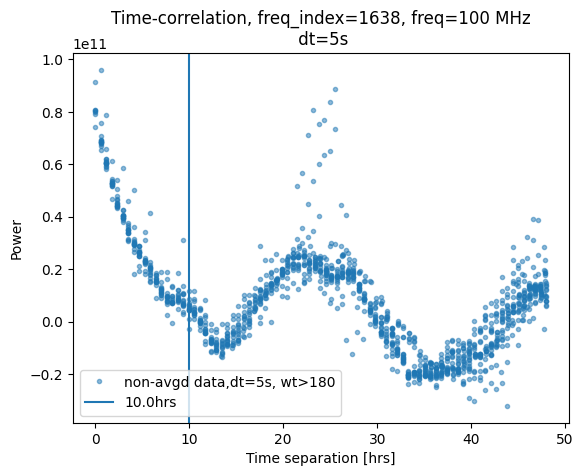

In [139]:
'''ACF with non-averaged data'''
dt=5 # seconds
plt.clf()

# tot,wt=make_acf((dd[:,freq_index]-dd[:,freq_index].mean()),tt,dt=dt,tmax=2*86400)
tot2,wt2=make_acf_alt(dd[:,freq_index]-dd[:,freq_index].mean(),tt,dt=dt,tmax=2*86400)
# tot,wt=make_acf(dd-dd.mean(),tt,dt=dt,tmax=2*86400)
# tvec=np.arange(len(tot))*dt
tvec2=np.arange(len(tot2))*dt
# mm=wt>30
mm2=wt2>30
# print('tvec[wt>30]:',tvec[mm])
# print('tvec2[wt2>30]:',tvec2[mm2])

# plt.plot(tvec2[mm2]/3600,(tot2[mm2]/wt2[mm2]),'.',label='non-avgd data,dt='+str(dt)+'s,wt>30',alpha=0.5)
# plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'.',label='i+1 version')



plt.title('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz\n dt='+str(dt)+'s')
plt.ylabel('Power')
plt.xlabel('Time separation [hrs]')

dt=5 # seconds

# tot,wt=make_acf((dd[:,freq_index]-dd[:,freq_index].mean()),tt,dt=dt,tmax=2*86400)
tot2,wt2=make_acf_alt(dd[:,freq_index]-dd[:,freq_index].mean(),tt,dt=dt,tmax=2*86400)
# tot,wt=make_acf(dd-dd.mean(),tt,dt=dt,tmax=2*86400)
# tvec=np.arange(len(tot))*dt
tvec2=np.arange(len(tot2))*dt
# mm=wt>30
mm2=wt2>180
# print('tvec[wt>30]:',tvec[mm])
# print('tvec2[wt2>30]:',tvec2[mm2])

plt.plot(tvec2[mm2]/3600,(tot2[mm2]/wt2[mm2]),'.',label='non-avgd data,dt='+str(dt)+'s, wt>180',alpha=0.5)
# plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'.',label='i+1 version')



plt.title('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz\n dt='+str(dt)+'s')
plt.ylabel('Power')
plt.xlabel('Time separation [hrs]')

'''ACF with averaged data'''
# dt=np.min(np.diff(smoothed_times))-1
print(dt)
# tot,wt=make_acf((dd[:,freq_index]-dd[:,freq_index].mean()),tt,dt=dt,tmax=2*86400)
tot3,wt3=make_acf_alt(smoothed_dat-smoothed_dat.mean(),smoothed_tt,dt=dt,tmax=2*86400)
# tot,wt=make_acf(dd-dd.mean(),tt,dt=dt,tmax=2*86400)
# tvec=np.arange(len(tot))*dt
tvec3=np.arange(len(tot3))*dt
# mm=wt>30
mm3=wt3>30
# print('tvec[wt>30]:',tvec[mm])
# print('tvec2[wt3>30]:',tvec3[mm3])

# plt.plot(tvec3[mm3]/3600,(tot3[mm3]/wt3[mm3]),'.',label='avgd data,dt={:.4g}s'.format(dt),alpha=0.5)
# plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'.',label='i+1 version')



'''Set dtmax here -- i.e. the section of the ACF data used to fit a function'''
dtmax = 10*3600 # seconds
'''------------------------------------'''

plt.axvline(x=dtmax/3600,label=str(dtmax/3600)+'hrs')

plt.legend()
plt.show()

bin larger than 5 minutes: 305
bin larger than 5 minutes: 305
bin larger than 5 minutes: 305
bin larger than 5 minutes: 305
bin larger than 5 minutes: 310
bin larger than 5 minutes: 310
bin larger than 5 minutes: 305
bin larger than 5 minutes: 305
bin larger than 5 minutes: 310
bin larger than 5 minutes: 305
bin larger than 5 minutes: 310
bin larger than 5 minutes: 310
bin larger than 5 minutes: 310
bin larger than 5 minutes: 310
bin larger than 5 minutes: 310
bin larger than 5 minutes: 305
bin larger than 5 minutes: 310
bin larger than 5 minutes: 310
bin larger than 5 minutes: 315
bin larger than 5 minutes: 310
bin larger than 5 minutes: 310
bin larger than 5 minutes: 310
bin larger than 5 minutes: 315
bin larger than 5 minutes: 315
bin larger than 5 minutes: 315
bin larger than 5 minutes: 320
bin larger than 5 minutes: 320
bin larger than 5 minutes: 315
bin larger than 5 minutes: 315
bin larger than 5 minutes: 310
bin larger than 5 minutes: 310
bin larger than 5 minutes: 310
bin larg

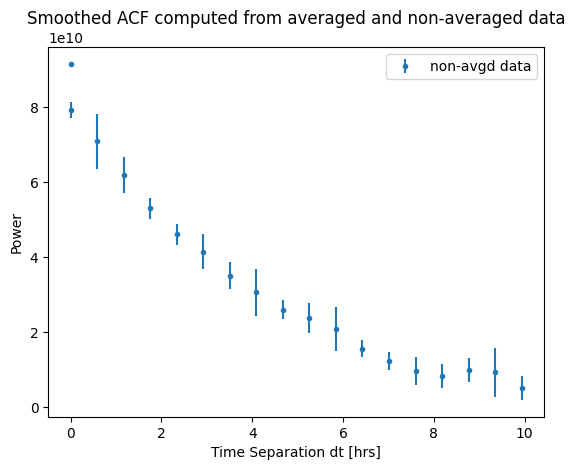

In [124]:
'''Smoothing the ACF by binning, but keeping the dt=0 bin/peak intact! -- NON AVERAGED DATA'''
# Separate the current dt values into bins within a few minutes of each other, I think this normally corresponds to data taken during the same rotation through calibrators before going back to antenna

# binwidth = 60*5 # 5 minute bins, 5*60 seconds time difference to be considered in the same bin

# Example array of time values in seconds (with large time gaps)
time_values = tvec2[mm2][1:]
acf_values = (tot2[mm2]/wt2[mm2])[1:]
zerobin = (tot2[mm2]/wt2[mm2])[0] # save the zero-bin
tsteps = np.diff(time_values)

# Define bin size (5 minutes = 5x60 seconds)
bin_size = 60*5

# Create bin edges based on big jumps in the timestep between subsequent measurements
bins = np.where(tsteps>5*60)[0]
# print(bins)

# Split 
bin_tgroups = np.split(time_values,bins+1,axis=0)
bin_acf_groups = np.split(acf_values,bins+1,axis=0)

t_binavg = []
acf_binavg = []
acf_binstd = []
largest_binwidth = 0

for i in range(len(bin_tgroups)):
    t_binavg.append(np.mean(bin_tgroups[i]))
    acf_binavg.append(np.mean(bin_acf_groups[i]))
    acf_binstd.append(np.std(bin_acf_groups[i]))
    if (bin_tgroups[i][-1]-bin_tgroups[i][0]) > 5*60:
        print('bin larger than 5 minutes:',bin_tgroups[i][-1]-bin_tgroups[i][0])
    if (bin_tgroups[i][-1]-bin_tgroups[i][0] > largest_binwidth):
        largest_binwidth = bin_tgroups[i][-1]-bin_tgroups[i][0]
        largest_bini = i

print(largest_binwidth/60,'mins')
print(largest_bini)

# Print the results
smoothed_times = np.concatenate(([0],t_binavg))
smoothed_acf = np.concatenate(([zerobin],acf_binavg))
smoothed_std = np.concatenate(([0],acf_binstd))
print(smoothed_std.shape)
print(smoothed_acf.shape)
# print("Average time for non-empty bins:", smoothed_times)
# print("Average acf value for non-empty bins:", smoothed_acf)

plt.errorbar(x=smoothed_times[smoothed_times<10*3600]/3600,y=smoothed_acf[smoothed_times<10*3600],yerr=smoothed_std[smoothed_times<10*3600],marker='.',ls='None',label='non-avgd data')
# plt.plot(smoothed_times/3600,smoothed_acf,'.')

'''WITH AVERAGED DATA'''

time_values = tvec3[mm3][1:]
acf_values = (tot3[mm3]/wt3[mm3])[1:]
zerobin = (tot3[mm3]/wt3[mm3])[0] # save the zero-bin
tsteps = np.diff(time_values)

# Define bin size (5 minutes = 5x60 seconds)
bin_size = 60*5

# Create bin edges based on big jumps in the timestep between subsequent measurements
bins = np.where(tsteps>5*60)[0]
# print(bins)

# Split 
bin_tgroups = np.split(time_values,bins+1,axis=0)
bin_acf_groups = np.split(acf_values,bins+1,axis=0)

t_binavg = []
acf_binavg = []
acf_binstd = []
largest_binwidth = 0

for i in range(len(bin_tgroups)):
    t_binavg.append(np.mean(bin_tgroups[i]))
    acf_binavg.append(np.mean(bin_acf_groups[i]))
    acf_binstd.append(np.std(bin_acf_groups[i]))
    if (bin_tgroups[i][-1]-bin_tgroups[i][0]) > 5*60:
        print('bin larger than 5 minutes:',bin_tgroups[i][-1]-bin_tgroups[i][0])
    if (bin_tgroups[i][-1]-bin_tgroups[i][0] > largest_binwidth):
        largest_binwidth = bin_tgroups[i][-1]-bin_tgroups[i][0]
        largest_bini = i

print(largest_binwidth/60,'mins')
print(largest_bini)

# Print the results
smoothed_times_avgd = np.concatenate(([0],t_binavg))
smoothed_acf_avgd = np.concatenate(([zerobin],acf_binavg))
smoothed_std_avgd = np.concatenate(([0],acf_binstd))
print(smoothed_std_avgd.shape)
print(smoothed_acf_avgd.shape)
# print("Average time for non-empty bins:", smoothed_times)
# print("Average acf value for non-empty bins:", smoothed_acf)

# plt.errorbar(x=smoothed_times_avgd[smoothed_times_avgd<10*3600]/3600,y=smoothed_acf_avgd[smoothed_times_avgd<10*3600],yerr=smoothed_std_avgd[smoothed_times_avgd<10*3600],marker='.',ls='None',label='avgd data',zorder=2)
# plt.plot(smoothed_times/3600,smoothed_acf,'.')
plt.title('Smoothed ACF computed from averaged and non-averaged data')
plt.xlabel('Time Separation dt [hrs]')
plt.ylabel('Power')
plt.legend()
plt.show()

In [22]:
print(np.min(np.diff(tt))) # minimum timestep between consecutive samples, in seconds

# Figure out height of dt=0 peak compared to neighbouring points
smoothed_acf[0] - smoothed_acf[1]

5.330339670181274


14701604076.508667

Since the autocorrelation function still looks a little weird, we will only focus use the dt = 0 to dt = 8h section.

Also we plot the data:

1634901301.4516778


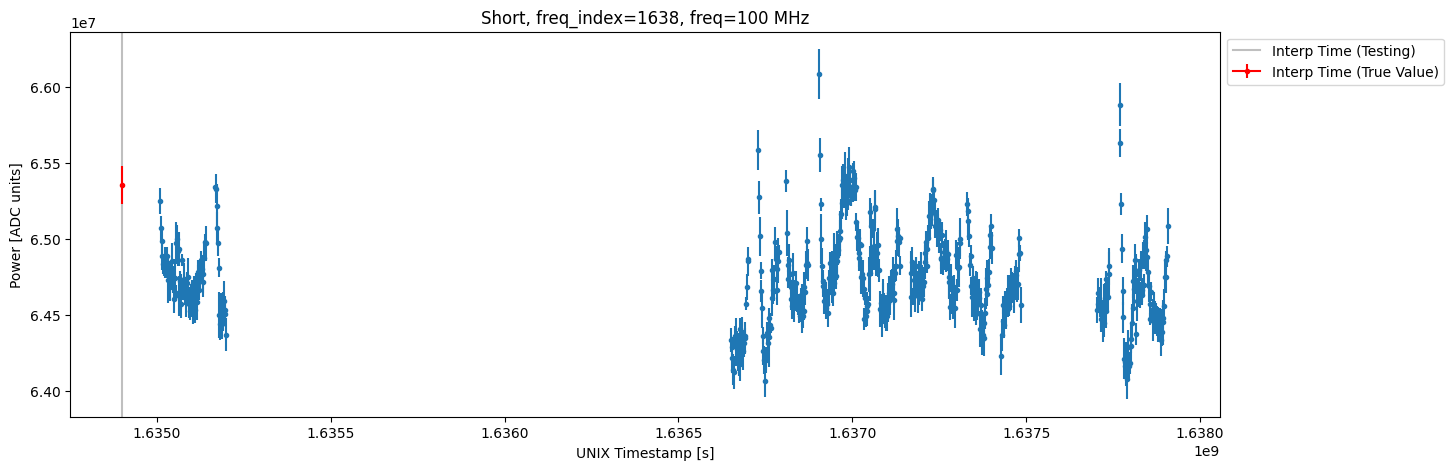

In [125]:
# vs UNIX timestamp

''' Set interp_time here'''
interp_time = t_ant[0] # +1 is because otherwise we get a nan in the Kriging.
print(interp_time)
'''--------------------'''

plt.figure(figsize=(20,5))
# plt.plot(t,dat[:,freq_index],'.',label='All times')
plt.errorbar(x=smoothed_tt,y=smoothed_dat,yerr=smoothed_dat_std,marker='.',ls='none')
plt.axvline(x=interp_time,label='Interp Time (Testing)',color='grey',zorder=1,alpha=0.5)
plt.errorbar(x=interp_time,y=smoothed_dat[195],yerr=smoothed_dat_std[195],label='Interp Time (True Value)',color='red',zorder=3,marker='.')
plt.xlabel('UNIX Timestamp [s]')
plt.ylabel('Power [ADC units]')
plt.title('Short, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.7)
plt.show()

# Step 2: Fit the autocorrelation function

In [126]:
# As a simple first pass for just the 0 to 8h section of the ACF we 
def linfunc(x,a,b):
    return a*x+b

def expfunc(x,a,b):
    return a*np.exp(-x/b)

# def expabsfunc(x,a,b):
#     return a*np.exp(-b*abs(x))

def ACF_fit(a,b,functype='linear'):
    if functype == 'linear':
        return lambda dt: a*dt+b
    elif functype == 'exponential':
        return lambda dt: a*np.exp(-dt/b)

def ACF_wgn(dt):
    if dt == 0: return np.random.normal(loc=1,scale=0.03,size=1)
    else: return np.random.normal(loc=0,scale=0.03,size=1)

[3.82888181e+07 3.72745024e+08 7.70301168e+08]


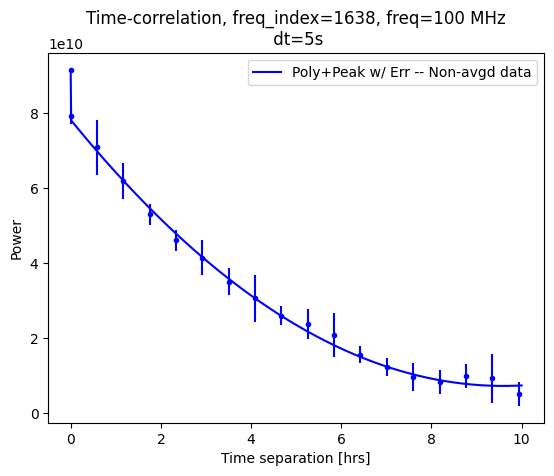

In [127]:
# plt.plot(tvec2[mm2][tvec2[mm2]<dtmax]/3600,(tot2[mm2]/wt2[mm2])[tvec2[mm2]<dtmax],'.',label='ACF Data, with dt=0 bin')
# plt.plot(tvec[mm][tvec[mm]<dtmax]/3600,(tot[mm]/wt[mm])[tvec[mm]<dtmax],'.',label='ACF Data, no dt=0 bin')
# plt.plot(smoothed_times[smoothed_times<10*3600]/3600,smoothed_acf[smoothed_times<10*3600],'.')
plt.errorbar(x=smoothed_times[smoothed_times<10*3600]/3600,y=smoothed_acf[smoothed_times<10*3600],yerr=smoothed_std[smoothed_times<10*3600],marker='.',ls='None',color='blue')
# plt.errorbar(x=smoothed_times_avgd[smoothed_times_avgd<10*3600]/3600,y=smoothed_acf_avgd[smoothed_times_avgd<10*3600],yerr=smoothed_std_avgd[smoothed_times_avgd<10*3600],marker='.',ls='None',color='red')


tfitvec = np.linspace(0,dtmax/3600,1000)

# Do the fit:

# ------------ parabola from 0< to 10, add peak height at dt=0
# c, cov = np.polyfit(x=smoothed_times[(0<smoothed_times)&(smoothed_times<10*3600)]/3600,y=smoothed_acf[(0<smoothed_times)&(smoothed_times<10*3600)],deg=2,cov=True)
# polyfunc = np.poly1d(c)
# print(np.diag(cov)**(1/2))

'''With non-averaged data'''
c_errs, coverrs = np.polyfit(x=smoothed_times[(0<smoothed_times)&(smoothed_times<10*3600)]/3600,y=smoothed_acf[(0<smoothed_times)&(smoothed_times<10*3600)],
                    w=1/smoothed_std[(0<smoothed_times)&(smoothed_times<10*3600)],deg=2,cov=True)
polyfunc_witherrs = np.poly1d(c_errs)
print(np.diag(coverrs)**(1/2))

zeropeak_height = abs(smoothed_acf[0] - smoothed_acf[1])

def delta_function(x, location=0, amplitude=zeropeak_height, width=1):
    delta = np.zeros_like(x)
    # Step 3: Add a sharp peak at the specified location
    idx = np.argmin(np.abs(x - location))  # Find the index closest to the location
    if x[idx] == location:
        # we only want the peak at exactly zero
        delta[idx:idx+width] = amplitude  # Set the value to amplitude (height of delta peak)
    return delta

def ACF_func_na(pf,dt):
    return pf(dt) + delta_function(dt,amplitude=zeropeak_height)

'''With averaged data'''
# c_errs_avgd, coverrs_avgd = np.polyfit(x=smoothed_times_avgd[(0<smoothed_times_avgd)&(smoothed_times_avgd<10*3600)]/3600,y=smoothed_acf_avgd[(0<smoothed_times_avgd)&(smoothed_times_avgd<10*3600)],
#                     w=1/smoothed_std_avgd[(0<smoothed_times_avgd)&(smoothed_times_avgd<10*3600)],deg=2,cov=True)
# polyfunc_witherrs_avgd = np.poly1d(c_errs_avgd)
# print(np.diag(coverrs_avgd)**(1/2))

# zeropeak_height = abs(smoothed_acf_avgd[0] - smoothed_acf_avgd[1])

# def ACF_func_a(pf,dt):
#     return pf(dt) + delta_function(dt,amplitude=zeropeak_height)

# plt.plot(tfitvec,ACF_func(polyfunc,tfitvec),label='Poly+Peak No Err')
plt.plot(tfitvec,ACF_func_na(polyfunc_witherrs,tfitvec),label='Poly+Peak w/ Err -- Non-avgd data',color='blue')
# plt.plot(tfitvec,ACF_func_a(polyfunc_witherrs_avgd,tfitvec),label='Poly+Peak w/ Err -- Avgd data',color='red')



# ---------------------------------------------------


plt.ylabel('Power')
plt.xlabel('Time separation [hrs]')
plt.title('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz\n dt='+str(dt)+'s')
plt.legend()
plt.show()

## Step 3: Build the covariance matrix

In [138]:
# "d": the data array, for convenience we put the point where we want to interpolate (marked by a 0) at the end 
# of the array of existing data

# "C": the covariance matrix of data d
'''Making a matrix with only the data within 8h of the interp time'''
# I had to reduce to 8h total (4h around interp time) interval so there's no need to use the ACF at dt > 8h
d_red = smoothed_dat[abs(smoothed_tt - interp_time) < dtmax/2] 
t_red = smoothed_tt[abs(smoothed_tt - interp_time) < dtmax/2]
d = np.append(d_red,0)
tarr = np.append(t_red,interp_time)
C = np.zeros(shape=(len(d),len(d))) # initialize
print(d_red)
'''--------------------------------------'''
# d = np.append(dd_gauss,0) # append 0 to end of data array
# d = np.append(dd,0)
# tarr = np.append(t_gauss,interp_time) # append the time where we want to generate an interpolated point
# C = np.zeros(shape=(len(d),len(d))) # initialize

# for i in range(len(d)):
#     for j in range(len(d)):
#         dtij = abs(tarr[i]-tarr[j]) # time separation between points
        
#         if dtij > dtmax:
#             # For now, we are only using the ACF up to dt = 8 hours. If dtij > 8h, set C_ij = 0 (uncorrelated).
# #             print('larger')
# #             print(dtij)
#             C[i,j] = 0
#             print('larger') # normally this should not happen since we've already truncated the array
#         else:
            
#             C[i,j] = ACF_func(dtij/3600) # ACF_func is defined for dt in hours

# Vectorizing the second loop:
for i in range(len(d)):
    ti = tarr[i]
    dtij_arr = abs(ti-tarr) # full array of the time separation from ti
    if np.any(dtij_arr>dtmax): print('larger') # normally this should not happen since we've already truncated the array
    
    C[i,:] = ACF_func_na(polyfunc_witherrs,dtij_arr/3600) # ACF_func is defined for dt in hours
    

''' Add a large constant to the covariance matrix to mitigate the non-zero mean issue'''
C += 1e14

[]


## Step 4: Invert the covariance matrix

In [129]:
Cinv = np.linalg.inv(C)
# print(Cinv@C)

# U, Sdiag, VT = np.linalg.svd(C, full_matrices=False) # SVD
# Cinv_svd = VT.T @ np.diag(1/Sdiag) @ U.T
# print(Cinv_svd@C)

# lam, Q = scipy.linalg.eig(C) # eigenvector/value
# lam = np.real(lam)
# Q = np.real(Q)
# # print(lam)
# Cinv_eig = Q @ np.diag(1/lam) @ np.linalg.inv(Q)
# print(Cinv_eig@C)

# print(Cinv_svd.shape)
# print(Cinv.shape)
# print(Cinv_eig.shape)
# print(np.sum(abs(Cinv-Cinv_svd)))
# print(np.sum(abs(Cinv-Cinv_eig)))

## Step 5: Compute the weights for each data point

The interpolated value consists of a weighted sum of existing data, where the weights are given by:

$$ w[1..n]= \frac{-C^{-1}[n+1,1..n]}{C^{-1}[n+1][n+1]} $$

where $n$ is the number of measured data points, and $n+1$ is due to adding the new interpolated point to the end of the data array.

In [135]:
# "w": array of weights for the weighted sum to compute inteprolated value
n = len(d)-1
w = -Cinv[n,0:n] / Cinv[n,n]

[]


## Step 6: Compute the weighted sum

In [131]:
dinterp = np.dot(w,d[0:n])
print(dinterp)
interp_err = np.sqrt(1/Cinv[n,n])
print(interp_err)
A = np.zeros(len(d))
A[n] = -1
interp_err = np.sqrt(1/(A.T@Cinv@A)) # just to verify it's the same thing
print(interp_err)

0.0
10004522.6958978
10004522.6958978


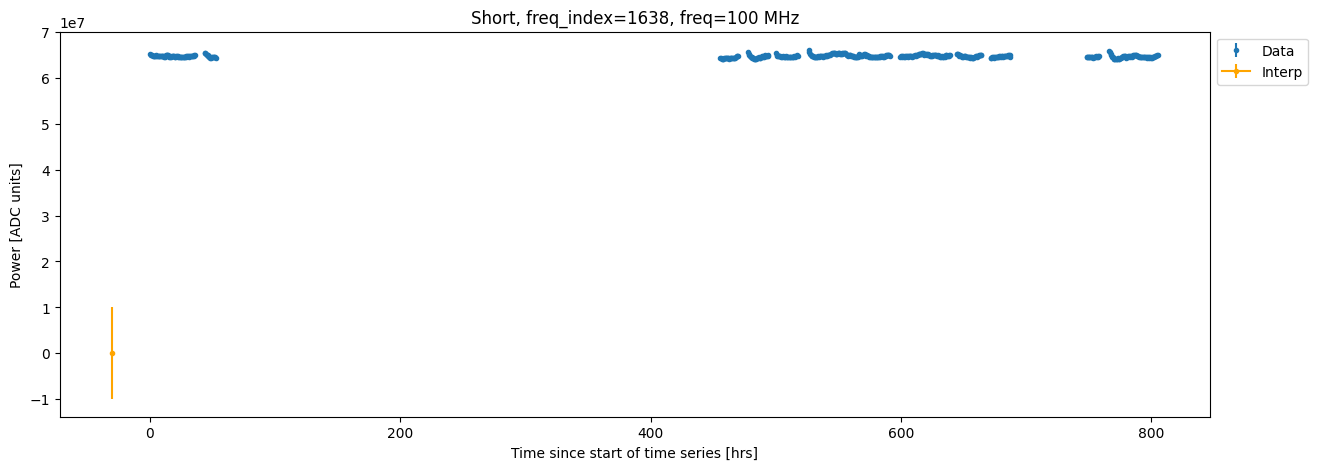

In [132]:
# Let's plot the result

plt.figure(figsize=(20,5))
# plt.plot((smoothed_tt-smoothed_tt[0])/3600,smoothed_dat,'.',label='Selected section',zorder=0)
# plt.axvline(x=(interp_time-tt[0])/3600,label='Interp Time (Testing)',color='orange',zorder=1) 

plt.errorbar(x=(smoothed_tt-smoothed_tt[0])/3600,y=smoothed_dat,yerr=smoothed_dat_std,marker='.',ls='none',label='Data')
# plt.errorbar(x=(interp_time-smoothed_tt[0])/3600,y=smoothed_dat[195],yerr=smoothed_dat_std[195],label='Interp Time (True Value)',color='red',zorder=3,marker='.')
plt.errorbar(x=(interp_time-smoothed_tt[0])/3600,y=dinterp,yerr=interp_err,color='orange',marker='.',label='Interp')
plt.xlabel('Time since start of time series [hrs]')
plt.ylabel('Power [ADC units]')
plt.title('Short, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.7)
# plt.xlim(left=500,right=600)
plt.show()

Hmmmm ok this does not look good.
Try plotting the weights to make sure it works?
Maybe the problem is with the proper inversion of the C matrix. Look into matrix decomposition tricks from phys 512.

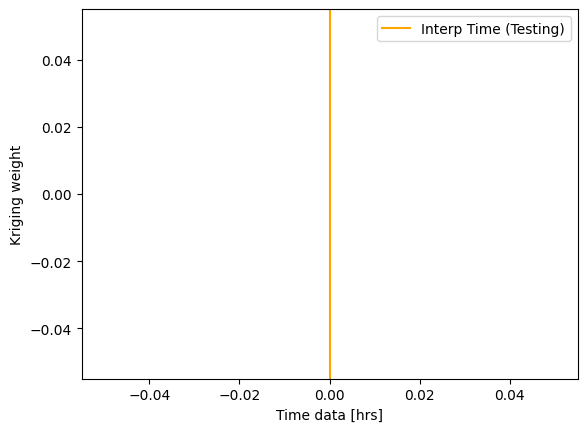

In [134]:
# plt.scatter(tt[abs(w)<100],w[abs(w)<100])
plt.scatter((t_red-interp_time)/3600,w)
plt.axvline(x=(interp_time-interp_time)/3600,label='Interp Time (Testing)',color='orange') 
plt.xlabel('Time data [hrs]')
plt.ylabel('Kriging weight')
plt.legend()
plt.show()

# why does this look like zero sometimes  and random other times????
# tt[w>200]